In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

ims = pd.read_csv('fer2013/fer2013.csv')
ims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [4]:
from skimage import color

# Convert image data into skimage format
pixels = []
for im in ims.pixels.values:
    x = np.array(im.split()).astype(float) # Convert to float array
    x = color.gray2rgb(x.reshape([48,48])) # Convert to image format
    pixels.append(x)

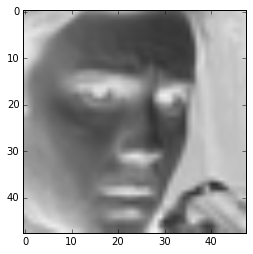

In [44]:
plt.imshow(pixels[0])

In [6]:
from skimage.filters import gabor_filter
ims.emotion.unique()
y = ims.emotion.values.astype(np.int32)
X = np.array([np.ravel(im) for im in pixels]).astype(np.float32)

In [33]:
y.shape

(35887,)

In [9]:
from lasagne import layers
from lasagne.nonlinearities import  sigmoid, softmax, rectify, tanh, linear
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

In [18]:
# Configure the neural network
nn = NeuralNet(
           # Specify the layers
           layers=[('input', layers.InputLayer),
                   ('hidden1', layers.DenseLayer),
                   ('output', layers.DenseLayer),
           ],

           # Input Layer
           input_shape=(None, X.shape[1]),

           # 1st Hidden Layer
           hidden1_num_units=20,
           hidden1_nonlinearity=tanh,

           # Output Layer
           output_num_units=7,
           output_nonlinearity=softmax,

           # Optimization
           update=nesterov_momentum,
           update_learning_rate=.1,
           update_momentum=0.9,
           max_epochs=100,

           # Others
           regression=False,
           verbose=1,
     )
nn.fit(X, y)


# Neural Network with 138407 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input      6912
  1  hidden1      20
  2  output        7

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.76474       1.72315      1.02414      0.32195  2.28s
      2       1.72232       1.72335      0.99940      0.31208  2.05s
      3       1.70700       1.71333      0.99630      0.31934  2.01s
      4       1.70114       1.69991      1.00072      0.33316  2.08s
      5       1.69028       1.70595      0.99081      0.32551  2.05s
      6       1.69239       1.69396      0.99908      0.33225  2.04s
      7       1.68207       1.69077      0.99485      0.33835  2.04s
      8       1.68149       1.70301      0.98737      0.33095  2.02s
      9       1.67385       1.69117      0.98976      0.33510  2.03s
     10       1.67110       1.69235      0.98744      0.33922  2

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x193559c10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x193559b90>,
     custom_score=None,
     hidden1_nonlinearity=<function tanh at 0x1931df9b0>,
     hidden1_num_units=20, input_shape=(None, 6912),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x1935b2398>,
     objective_loss_function=<function categorical_crossentropy at 0x193327230>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x193e36170>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1944c7a28>],
     output_nonlinearity=<function softmax at 0x1931df938>,
     output_num_units=7, regressio

In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X = ss.fit_transform(X)

In [30]:
import pystasm
reload(pystasm)

<module 'pystasm' from 'pystasm.py'>

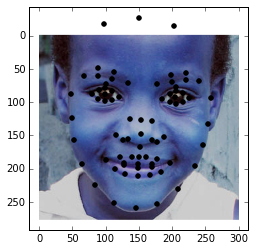

In [43]:
s = pystasm.STASM()
landmarks = s.s_search_single('stasm4.1.0/data/testface.jpg')
plt.imshow(cv2.imread('stasm4.1.0/data/testface.jpg', 1))
plt.scatter(landmarks[:, 0], landmarks[:, 1], c = 'black')

In [46]:
for i, im in enumerate(pixels):
    cv2.imwrite('fer2013/images/{}.jpg'.format(i), im)

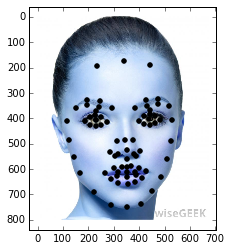

In [91]:
s = pystasm.STASM()
lm_test = s.s_search_single('triangular-face.jpg')
plt.imshow(cv2.imread('triangular-face.jpg'))
plt.scatter(lm_test[:, 0], lm_test[:, 1], c = 'black')

In [96]:
cv2.imread('triangular-face.jpg').shape

(800, 668, 3)

In [92]:
def build_filters():
    filters = []
    ksize = 9
    for theta in np.arange(0, np.pi, np.pi / 8):
        for lamda in np.arange(0, np.pi, np.pi/4): 
            kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [93]:
filters = build_filters()

In [95]:
lm_test[:, 1].astype(int)

array([409, 487, 551, 617, 689, 740, 751, 736, 687, 632, 560, 490, 408,
       191, 173, 194, 333, 328, 358, 348, 354, 361, 360, 329, 322, 353,
       343, 351, 367, 372, 413, 395, 388, 395, 411, 425, 430, 425, 405,
       402, 411, 392, 384, 390, 405, 419, 425, 421, 484, 486, 488, 542,
       524, 541, 529, 547, 561, 548, 531, 614, 597, 590, 590, 589, 595,
       608, 610, 612, 612, 626, 632, 625, 637, 653, 660, 656, 641])

array([28, 22, 25, 25, 16, 20, 12, 14, 20, 18, 19, 19, 23, 28, 32, 33, 33,
       81, 19, 30, 28, 27, 34, 14, 26, 23, 31, 28, 24, 23,  6,  0, 13, 28,
       40, 44, 48, 23,  0,  2, 30, 14,  0, 18, 11, 21, 44, 31, 25, 32, 31,
       24, 31, 28, 31,  1, 20, 18, 33, 20, 28, 27, 26, 20, 26, 24, 20, 18,
       16, 37, 10, 20, 28, 18, 21, 24, 38], dtype=uint8)

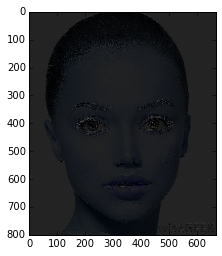

In [105]:
plt.imshow(process(cv2.imread('triangular-face.jpg'), filters[0]), cmap='gray')
conv = process(cv2.imread('triangular-face.jpg', 0), filters[0])[lm_test[:, 1].astype(int)
                                                       , lm_test[:, 0].astype(int)]
# plt.scatter(conv[:, 0], conv[:, 1])
conv

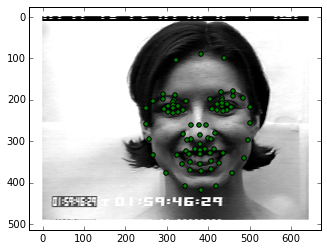

In [84]:
test = cv2.imread('cohn-kanade-images/S010/006/S010_006_00000015.png')
s = pystasm.STASM()
lms = s.s_search_single('cohn-kanade-images/S010/006/S010_006_00000015.png')
plt.imshow(test)
plt.scatter(lms[:, 0], lms[:, 1], c = 'green')